In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Data

Consider a high-dimensional dataset, with 100 features, say, normally distributed with covariance $I_{100}$. We take a linear combination of the data (suppose it is simply a sum of the different features), and compute a non-linear function of it, say, cosine.

We wish to determine whether a neural network performs better at fitting the data compared to an SVM.

Later, on observing the performance on this dataset, we also consider data from a normal distribution but with a non-trivial covariance, which is dependent on w (100 * $1_{100}$), say, $I + w.w^T$.

In [2]:
DATA_SIZE = 10000
NUM_FEATURES = 100

In [3]:
from torch.distributions import MultivariateNormal
from sklearn.model_selection import train_test_split

### Uncorrelated

In [4]:
uncorrelated_distribution = MultivariateNormal(torch.zeros(NUM_FEATURES), torch.eye(NUM_FEATURES))

In [5]:
X_uncorrelated = uncorrelated_distribution.sample((DATA_SIZE,))
X_uncorrelated.shape

torch.Size([10000, 100])

In [6]:
# X_sum_sorted = torch.sort(X_uncorrelated.sum(dim=1)).values
# index_5_percent = int(0.05 * len(X_uncorrelated))
# scale_factor = torch.max(torch.abs(X_sum_sorted[index_5_percent]), torch.abs(X_sum_sorted[-index_5_percent])) / torch.max(X_sum_sorted)
scale_factor = 5 * torch.pi / torch.max(torch.abs(X_uncorrelated.sum(dim=1)))
# scale_factor = 1.
scale_factor

tensor(0.3700)

In [7]:
X_uncorrelated_scaled = X_uncorrelated * scale_factor

In [8]:
Y_uncorrelated = torch.cos(X_uncorrelated_scaled.sum(dim=1)).reshape(-1, 1) + torch.randn(len(X_uncorrelated), 1) * 0.05
Y_uncorrelated.shape

torch.Size([10000, 1])

Text(0, 0.5, 'Y')

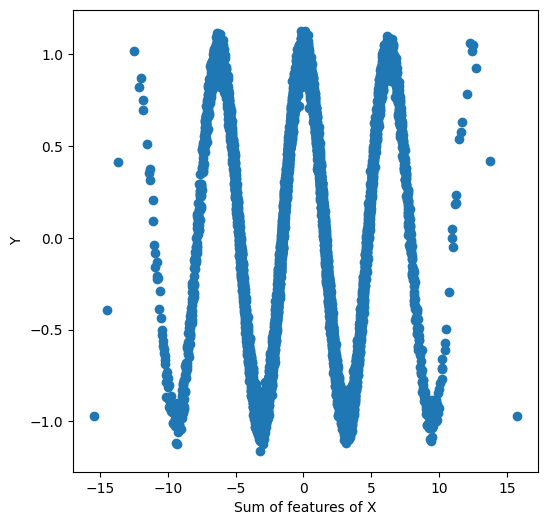

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(X_uncorrelated_scaled.sum(dim=1), Y_uncorrelated)
plt.xlabel('Sum of features of X')
plt.ylabel('Y')

In [10]:
X_training, X_test, Y_training, Y_test = train_test_split(X_uncorrelated_scaled, Y_uncorrelated, test_size=1000)
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=1000)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([8000, 100]),
 torch.Size([8000, 1]),
 torch.Size([1000, 100]),
 torch.Size([1000, 1]),
 torch.Size([1000, 100]),
 torch.Size([1000, 1]))

In [11]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, 32, True), make_dataloader(X_val, Y_val, 32, True)

## Models

## Neural network

In [12]:
device = 'cpu'

In [13]:
depths = [1, 2, 3, 4, 5]
widths = [16, 32, 64]
activations = [torch.nn.ReLU(), torch.nn.Tanh()]
etas = [1e-4, 1e-3, 1e-2]
weight_decays = np.logspace(-4, 4, 9).tolist()
weight_decays.append(0.0)
betass = [(0.9, 0.999), (0.8, 0.9), (0., 0.)]

In [14]:
best_score = -torch.inf
best_depth = None
best_width = None
best_activation = None
best_eta = None
best_weight_decay = None
best_betas = None

In [15]:
from scripts.train import train_model
from scripts.models import SimpleNN
from scripts.metrics import NegMeanSquaredError

total_count = len(depths) * len(widths) * len(activations) * len(etas) * len(weight_decays) * len(betass)
curr_count = 0
EPOCHS = 20
print(f'Cross validating across {total_count} models.\n')

for depth in depths:
    for width in widths:
        for activation in activations:
            for eta in etas:
                for weight_decay in weight_decays:
                    for betas in betass:
                        curr_count += 1
                        model = SimpleNN(NUM_FEATURES, activation=activation, task_type='regression', hidden_layers=depth, hidden_units=width).to(device)
                        history = train_model(
                            model=model,
                            train_dataloader=train_dataloader,
                            val_dataloader=val_dataloader,
                            loss_fn=torch.nn.MSELoss(),
                            optimizer=torch.optim.Adam(params=model.parameters(), lr=eta, betas=betas, weight_decay=weight_decay),
                            metric=NegMeanSquaredError(),
                            epochs=EPOCHS,
                            verbose=0,
                            device=device
                        )
                        curr_score = history['val_score'][-1]
                        if curr_score > best_score:
                            best_score = curr_score
                            best_depth = depth
                            best_width = width
                            best_activation = activation
                            best_eta = eta
                            best_weight_decay = weight_decay
                            best_betas = betas
                        print(f'[{curr_count}/{total_count}]\tDepth:{depth}, Width:{width}, Actn.:{activation}, lr:{eta}, w_d:{weight_decay}, betas:{betas} => Score:{curr_score:.6f}')

print(f'\nBest validation score after {EPOCHS} epochs: {best_score:.6f}. Best configuration:')
print(f'Depth:{best_depth}, Width:{best_width}, Actn.:{best_activation}, lr:{best_eta}, w_d:{best_weight_decay}, betas:{best_betas}')

Cross validating across 2700 models.

[1/2700]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.0001, betas:(0.9, 0.999) => Score:-0.500554
[2/2700]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.0001, betas:(0.8, 0.9) => Score:-0.500712
[3/2700]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.0001, betas:(0.0, 0.0) => Score:-0.499033
[4/2700]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.001, betas:(0.9, 0.999) => Score:-0.502620
[5/2700]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.001, betas:(0.8, 0.9) => Score:-0.506347
[6/2700]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.001, betas:(0.0, 0.0) => Score:-0.500263
[7/2700]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.01, betas:(0.9, 0.999) => Score:-0.498708
[8/2700]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.01, betas:(0.8, 0.9) => Score:-0.500702
[9/2700]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.01, betas:(0.0, 0.0) => Score:-0.496934
[10/2700]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_

In [16]:
from scripts.models import SimpleNN

best_model_nn = SimpleNN(NUM_FEATURES, activation=best_activation, hidden_layers=best_depth, hidden_units=best_width, task_type='regression').to(device)

In [17]:
from scripts.metrics import NegMeanSquaredError
from scripts.utils import EarlyStopping

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=best_model_nn.parameters(), lr=best_eta, weight_decay=best_weight_decay, betas=best_betas)
metric = NegMeanSquaredError()
early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [18]:
from scripts.train import train_model

history = train_model(
    model=best_model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stop,
    device=device
)

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.523900, Train score: -0.523900, Val loss: 0.511311, Val score: -0.511311
Epoch: 2 => Train loss: 0.509152, Train score: -0.509152, Val loss: 0.502046, Val score: -0.502046
Epoch: 3 => Train loss: 0.503415, Train score: -0.503415, Val loss: 0.496689, Val score: -0.496689
Epoch: 4 => Train loss: 0.501628, Train score: -0.501628, Val loss: 0.493992, Val score: -0.493992
Epoch: 5 => Train loss: 0.501044, Train score: -0.501044, Val loss: 0.500131, Val score: -0.500131
Epoch: 6 => Train loss: 0.500881, Train score: -0.500881, Val loss: 0.496826, Val score: -0.496826
Epoch: 7 => Train loss: 0.500853, Train score: -0.500853, Val loss: 0.493412, Val score: -0.493412
Epoch: 8 => Train loss: 0.500815, Train score: -0.500815, Val loss: 0.500242, Val score: -0.500242
Epoch: 9 => Train loss: 0.500807, Train score: -0.500807, Val loss: 0.494737, Val score: -0.494737
Epoch: 10 => Train loss: 0.500811, Train score: -0.500

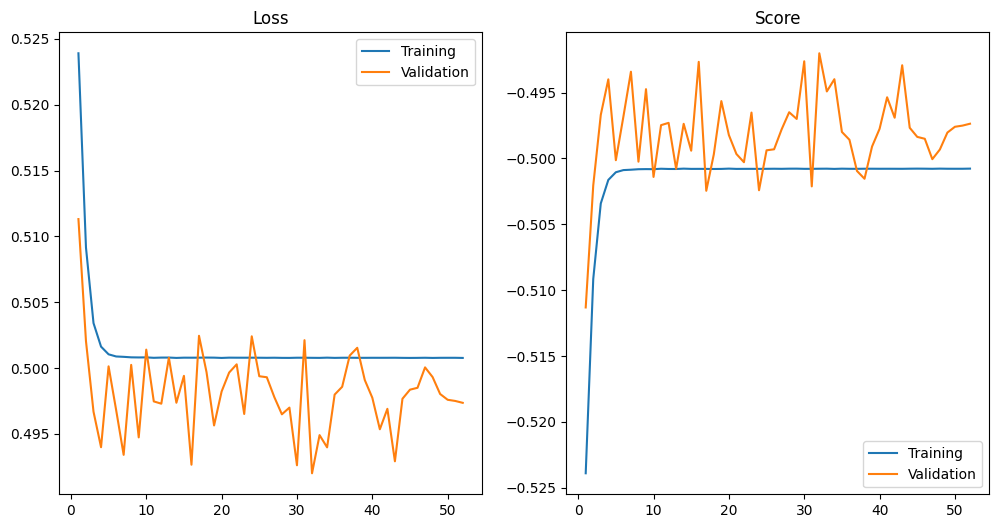

In [19]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [20]:
from scripts.test import predict

preds_train, preds_val = predict(best_model_nn, X_train, device), predict(best_model_nn, X_val, device)
preds_train.shape, preds_val.shape

(torch.Size([8000, 1]), torch.Size([1000, 1]))

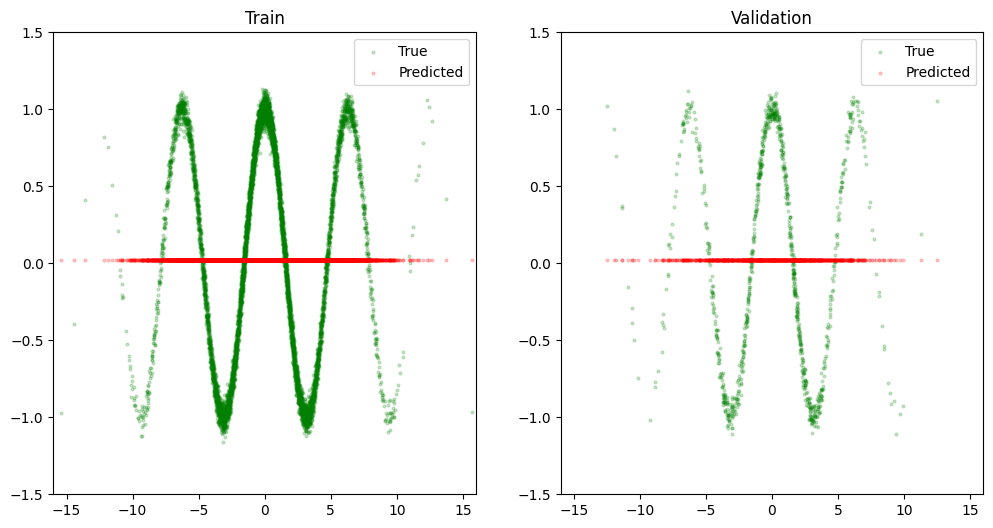

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(X_train.sum(dim=1), Y_train, c='g', label='True', s=4, alpha=0.2)
plt.scatter(X_train.sum(dim=1), preds_train, c='r', label='Predicted', s=4, alpha=0.2)
plt.title('Train')
plt.xlim(-16, 16)
plt.ylim(-1.5, 1.5)
plt.legend()

plt.subplot(122)
plt.scatter(X_val.sum(dim=1), Y_val, c='g', label='True', s=4, alpha=0.2)
plt.scatter(X_val.sum(dim=1), preds_val, c='r', label='Predicted', s=4, alpha=0.2)
plt.title('Validation')
plt.xlim(-16, 16)
plt.ylim(-1.5, 1.5)
plt.legend()